### Packages


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import math
import numpy as np 

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Basic operations on tensor

In [2]:
torch.empty(2,2)

tensor([[0., 0.],
        [0., 0.]])

In [3]:
torch.rand(2,2)

tensor([[0.3220, 0.2891],
        [0.2625, 0.5638]])

In [4]:
torch.ones(2,2,dtype=torch.int)

tensor([[1, 1],
        [1, 1]], dtype=torch.int32)

In [5]:
torch.tensor([25,10]).size()

torch.Size([2])

In [6]:
x = torch.rand(3,3)
y = torch.rand(3,3)
x / y == torch.div(x,y)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

In [7]:
x

tensor([[0.2301, 0.3728, 0.0178],
        [0.7105, 0.4863, 0.0884],
        [0.8769, 0.6135, 0.8936]])

In [8]:
x[:,0]

tensor([0.2301, 0.7105, 0.8769])

In [9]:
x[1,1].item()

0.4862581491470337

In [10]:
x.view(9,1)

tensor([[0.2301],
        [0.3728],
        [0.0178],
        [0.7105],
        [0.4863],
        [0.0884],
        [0.8769],
        [0.6135],
        [0.8936]])

In [11]:
x.add_(1)

tensor([[1.2301, 1.3728, 1.0178],
        [1.7105, 1.4863, 1.0884],
        [1.8769, 1.6135, 1.8936]])

In [12]:
x + 1

tensor([[2.2301, 2.3728, 2.0178],
        [2.7105, 2.4863, 2.0884],
        [2.8769, 2.6135, 2.8936]])

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    x = torch.ones(5, device=device)
    y = torch.ones(5)
    y = y.to(device)
    z = x+y
    z = z.to('cpu')
    print(z)

tensor([2., 2., 2., 2., 2.])


### Autograd

In [14]:
x = torch.rand(3, requires_grad=True)
y = x+2
z = y**2 + 2
z = z.mean()
x

tensor([0.6201, 0.4340, 0.3053], requires_grad=True)

In [15]:
# z.backward() calculates gradients and stores them 
# as a [grad] attribute for each variable of x tensor
z.backward() # dz/dx = dz/dy * dy/dx [chain rule]
z, x.grad

(tensor(8.0346, grad_fn=<MeanBackward0>), tensor([1.7467, 1.6227, 1.5369]))

In [16]:
# 3 options
x.requires_grad_(False)
y = x.detach() # copy of x without gradient
with torch.no_grad():
    y = x+2
    print(y)

tensor([2.6201, 2.4340, 2.3053])


In [17]:
w = torch.ones(4, requires_grad = True)
for epoch in range(3):
    model_out = (w+3).sum()
    model_out.backward()
    print(w.grad) # how much change of model_out affects w
    w.grad.zero_() # zeroing tensor gradient

tensor([1., 1., 1., 1.])
tensor([1., 1., 1., 1.])
tensor([1., 1., 1., 1.])


In [18]:
# model_out -> m
# dm / dw = d((w+3).sum()) / dw
# dm / dw = sum_i [ d(w[i]+3) / dw[i] ]
# d(w[i]+3) / dw[i] = 1

### Backpropagation

In [19]:
x = torch.tensor(1.0)
y = torch.tensor(2.0)
w = torch.tensor(1.0, requires_grad=True)

# forward pass
y_hat = w * x
loss = (y_hat - y)**2

# backward
loss.backward() 
print(w.grad)
# loss function gradient
# dJ/dw = dJ/dy_hat * dy_hat/dw

# update w
lr = 0.1
w_update = -lr * w.grad
w + w_update

tensor(-2.)


tensor(1.2000, grad_fn=<AddBackward0>)

### Gradient Descent

In [20]:
# Linear regression
# f = w * x 

# here : f = 2 * x
X = np.array([1, 2, 3, 4], dtype=np.float32)
Y = np.array([2, 4, 6, 8], dtype=np.float32)
w = 0.0

def forward(x):
    return w * x

# loss = MSE
def loss(y, y_pred):
    return ((y_pred - y)**2).mean()

# J = 1/N * (w*x - y)**2
# dJ/dw = 1/N * 2x(w*x - y)
def gradient(x, y, y_pred):
    return (2*x*(y_pred - y)).mean()

print(f'Prediction before training: f(5) = {forward(5):.3f}')

# Training
learning_rate = 0.01
n_iters = 20

for epoch in range(n_iters):
    y_pred = forward(X)
    l = loss(Y, y_pred)
    dw = gradient(X, Y, y_pred)
    w -= learning_rate * dw

    if epoch % 5 == 0:
        print(f'epoch {epoch+1}: w = {w:.3f}, loss = {l:.8f}')
     
print(f'Prediction after training: f(5) = {forward(5):.3f}')

Prediction before training: f(5) = 0.000
epoch 1: w = 0.300, loss = 30.00000000
epoch 6: w = 1.246, loss = 5.90623236
epoch 11: w = 1.665, loss = 1.16278565
epoch 16: w = 1.851, loss = 0.22892293
Prediction after training: f(5) = 9.612


In [21]:
X = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
Y = torch.tensor([2, 4, 6, 8], dtype=torch.float32)
w = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

def forward(x):
    return w * x

def loss(y, y_pred):
    return ((y_pred - y)**2).mean()

print(f'Prediction before training: f(5) = {forward(5).item():.3f}')

learning_rate = 0.01
n_iters = 100

for epoch in range(n_iters):
    y_pred = forward(X)
    l = loss(Y, y_pred)
    l.backward()

    with torch.no_grad():
        w -= learning_rate * w.grad
    
    w.grad.zero_()

    if epoch % 10 == 0:
        print(f'epoch {epoch+1}: w = {w.item():.3f}, loss = {l.item():.8f}')

print(f'Prediction after training: f(5) = {forward(5).item():.3f}')

Prediction before training: f(5) = 0.000
epoch 1: w = 0.300, loss = 30.00000000
epoch 11: w = 1.665, loss = 1.16278565
epoch 21: w = 1.934, loss = 0.04506890
epoch 31: w = 1.987, loss = 0.00174685
epoch 41: w = 1.997, loss = 0.00006770
epoch 51: w = 1.999, loss = 0.00000262
epoch 61: w = 2.000, loss = 0.00000010
epoch 71: w = 2.000, loss = 0.00000000
epoch 81: w = 2.000, loss = 0.00000000
epoch 91: w = 2.000, loss = 0.00000000
Prediction after training: f(5) = 10.000


### Training pipeline

In [22]:
X = torch.tensor([[1], [2], [3], [4]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

n_samples, n_features = X.shape
print(f'#samples: {n_samples}, #features: {n_features}')

X_test = torch.tensor([5], dtype=torch.float32)
input_size = n_features
output_size = n_features

model = nn.Linear(input_size, output_size) # y = wx + b - linear transformation

learning_rate = 0.01
n_iters = 100

loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(n_iters):
    y_pred = model(X)
    l = loss(Y, y_pred)
    l.backward()
    optimizer.step() # update weights
    optimizer.zero_grad()

    if epoch % 10 == 0:
        [w,b] = model.parameters()
        print('epoch ', epoch+1, ': w = ', w[0][0].item(), 'b = ', b[0].item(), ' loss = ', l.item())
        
print(f'Prediction after training: f(5) = {forward(5).item():.3f}')

#samples: 4, #features: 1
epoch  1 : w =  0.5972176194190979 b =  0.9450058937072754  loss =  12.88611125946045
epoch  11 : w =  1.423363208770752 b =  1.1839882135391235  loss =  0.5834311246871948
epoch  21 : w =  1.5666160583496094 b =  1.1919444799423218  loss =  0.25057828426361084
epoch  31 : w =  1.5997200012207031 b =  1.1636409759521484  loss =  0.22826024889945984
epoch  41 : w =  1.614809513092041 b =  1.1303790807724  loss =  0.21477416157722473
epoch  51 : w =  1.6267127990722656 b =  1.0971676111221313  loss =  0.20226800441741943
epoch  61 : w =  1.6378237009048462 b =  1.0647871494293213  loss =  0.19049477577209473
epoch  71 : w =  1.6485356092453003 b =  1.0333393812179565  loss =  0.1794070303440094
epoch  81 : w =  1.6589196920394897 b =  1.0028163194656372  loss =  0.16896453499794006
epoch  91 : w =  1.6689951419830322 b =  0.9731943011283875  loss =  0.15912994742393494
Prediction after training: f(5) = 8.389


In [23]:
class LinearRegression(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.lin = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.lin(x)
    

epoch: 10, loss = 4034.9734
epoch: 20, loss = 2844.4893
epoch: 30, loss = 2032.8124
epoch: 40, loss = 1479.2919
epoch: 50, loss = 1101.7423
epoch: 60, loss = 844.1690
epoch: 70, loss = 668.4117
epoch: 80, loss = 548.4589
epoch: 90, loss = 466.5770
epoch: 100, loss = 410.6725


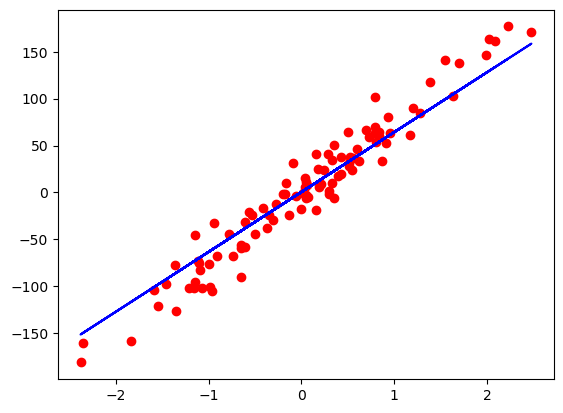

In [24]:
X_numpy, y_numpy = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=4)

X = torch.from_numpy(X_numpy.astype(np.float32))
y = torch.from_numpy(y_numpy.astype(np.float32))
y = y.view(y.shape[0], 1)

n_samples, n_features = X.shape
input_size = n_features
output_size = 1

model = LinearRegression(input_size, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  

num_epochs = 100
for epoch in range(num_epochs):
    y_predicted = model(X)
    loss = criterion(y_predicted, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

predicted = model(X).detach().numpy()
plt.plot(X_numpy, y_numpy, 'ro')
plt.plot(X_numpy, predicted, 'b')
plt.show()

In [25]:
class LogisticRegression(nn.Module):
    def __init__(self, input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_features, 1)
    
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred


In [26]:
bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target 

n_samples, n_features = X.shape # 569, 30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

model = LogisticRegression(n_features)

epochs = 100
lr = 0.01
loss_f = nn.BCELoss()
optim = torch.optim.SGD(model.parameters(), lr=lr)

# for epoch in tqdm(range(epochs)):
for epoch in range(epochs):
    y_pred = model(X_train)
    loss=loss_f(y_pred, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

with torch.no_grad():
    y_pred = model(X_test)
    y_pred_cls = y_pred.round()
    acc = y_pred_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy: {acc.item():.4f}')

accuracy: 0.4298


### DataLoader

In [27]:
class WineDataset(Dataset):
    def __init__(self):
        xy = np.loadtxt('data/wine.csv', delimiter=',', dtype=np.float32, skiprows=1)
        self.x = torch.from_numpy(xy[:,1:])
        self.y = torch.from_numpy(xy[:,[0]]) # models expect labels with (n_samples, 1) shapes
        self.n_samples = xy.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    
dataset = WineDataset()
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True, num_workers=2)

# dataiter = iter(dataloader)
# data = next(dataiter)

# training loop
num_epochs = 2
total_samples = len(dataset)
n_iter = math.ceil(total_samples/4)
print(total_samples, n_iter)

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(dataloader):
         if (i+1) % 5 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iter}| Inputs {inputs.shape} | Labels {labels.shape}')


177 45
Epoch: 1/2, Step 5/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 10/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 15/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 20/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 25/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 30/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 35/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 40/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 45/45| Inputs torch.Size([1, 13]) | Labels torch.Size([1, 1])
Epoch: 2/2, Step 5/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 2/2, Step 10/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 2/2, Step 15/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 2/2, Step 20/45| Inputs torch.Size([4, 1

### Dataset transforms

In [28]:
class WineDataset(Dataset):
    def __init__(self, transform=None):
        xy = np.loadtxt('data/wine.csv', delimiter=',', dtype=np.float32, skiprows=1)
        self.x = xy[:,1:]
        self.y = xy[:,[0]]
        self.n_samples = xy.shape[0]
        self.transform = transform
        
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return self.n_samples
    
class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)
    
class MulTransform:
    def __init__(self, factor):
        self.factor = factor
    
    def __call__(self, sample):
        inputs, targets = sample
        inputs *= self.factor
        return inputs, targets
    
print('No transform:')
dataset = WineDataset()
first_data = dataset[0]
features, labels = first_data
print(type(features), type(labels))
print(features, labels)

print('\nTensor transform:')
dataset = WineDataset(transform=ToTensor())
first_data = dataset[0]
features, labels = first_data
print(type(features), type(labels))
print(features, labels)

print('\nMul and tensor transform:')
composed = torchvision.transforms.Compose([ToTensor(), MulTransform(4)])
dataset = WineDataset(transform=composed)
first_data = dataset[0]
features, labels = first_data
print(type(features), type(labels))
print(features, labels)

No transform:
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[1.32e+01 1.78e+00 2.14e+00 1.12e+01 1.00e+02 2.65e+00 2.76e+00 2.60e-01
 1.28e+00 4.38e+00 1.05e+00 3.40e+00 1.05e+03] [1.]

Tensor transform:
<class 'torch.Tensor'> <class 'torch.Tensor'>
tensor([1.3200e+01, 1.7800e+00, 2.1400e+00, 1.1200e+01, 1.0000e+02, 2.6500e+00,
        2.7600e+00, 2.6000e-01, 1.2800e+00, 4.3800e+00, 1.0500e+00, 3.4000e+00,
        1.0500e+03]) tensor([1.])

Mul and tensor transform:
<class 'torch.Tensor'> <class 'torch.Tensor'>
tensor([5.2800e+01, 7.1200e+00, 8.5600e+00, 4.4800e+01, 4.0000e+02, 1.0600e+01,
        1.1040e+01, 1.0400e+00, 5.1200e+00, 1.7520e+01, 4.2000e+00, 1.3600e+01,
        4.2000e+03]) tensor([1.])


### Softmax and CrossEntropy

In [29]:
loss = nn.CrossEntropyLoss()

Y = torch.tensor([0])

Y_pred_good = torch.tensor([[2.0, 1.0, 0.1]])
Y_pred_bad = torch.tensor([[0.5, 2.0, 0.3]])
l1 = loss(Y_pred_good, Y)
l2 = loss(Y_pred_bad, Y)

l1.item(), l2.item() # good prediciton has lower CEloss

(0.4170299470424652, 1.840616226196289)

In [30]:
v, i = torch.max(Y_pred_good, 1)
torch.max(Y_pred_good, 1)

torch.return_types.max(
values=tensor([2.]),
indices=tensor([0]))

### Feed Forward Network

torch.Size([64, 1, 28, 28]) torch.Size([64])


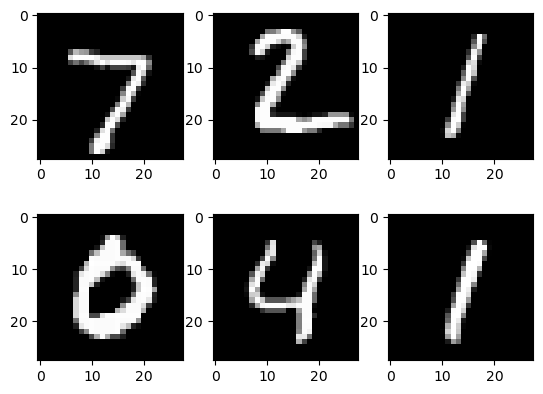

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 2
batch_size = 64
learning_rate = 0.001

train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

examples = iter(test_loader)
example_data, example_targets = next(examples)

print(example_data.shape, example_targets.shape)

plt.style.use('default')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

torchvision.utils.make_grid(example_data)

In [32]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out
    
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = ce_loss(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 97.44 %


### CNN

In [33]:
import torch.nn.functional as F

num_epochs = 1
batch_size = 4
learning_rate = 0.001

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# 32x32 60k train set, 10k test set
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, 
                                            download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='data', train=False,
                                            download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


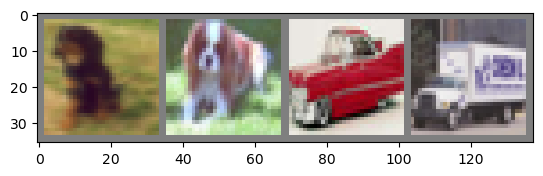

In [34]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [35]:
images[0].shape

torch.Size([3, 32, 32])

In [36]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  
        self.pool = nn.MaxPool2d(2, 2)  
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x)) # 32 x 32 x 3  ->  28 x 28 x 6 
        x = self.pool(x)          # 28 x 28 x 6  ->  14 x 14 x 6
        x = F.relu(self.conv2(x)) # 14 x 14 x 6  ->  10 x 10 x 16
        x = self.pool(x)          # 10 x 10 x 16 ->  5  x 5  x 16
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # no need for softmax since it is already included in loss function
        return x
        
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
train = True
n_total_steps = len(train_loader)

if train:
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # 32 x 32 x 3 x 4
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 2000 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    print('Finished Training')
    PATH = './cnn.pth'
    torch.save(model.state_dict(), PATH)

Epoch [1/1], Step [2000/12500], Loss: 1.9291
Epoch [1/1], Step [4000/12500], Loss: 2.5692
Epoch [1/1], Step [6000/12500], Loss: 1.9417
Epoch [1/1], Step [8000/12500], Loss: 1.7397
Epoch [1/1], Step [10000/12500], Loss: 1.5289
Epoch [1/1], Step [12000/12500], Loss: 1.6707
Finished Training


In [38]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [39]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for _, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 48.08 %
Accuracy of plane: 56.8 %
Accuracy of car: 76.3 %
Accuracy of bird: 41.3 %
Accuracy of cat: 18.9 %
Accuracy of deer: 10.8 %
Accuracy of dog: 51.6 %
Accuracy of frog: 52.5 %
Accuracy of horse: 56.5 %
Accuracy of ship: 58.4 %
Accuracy of truck: 57.7 %


### Transfer Learning

In [40]:
import os, time, copy
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # random pos 224 x 224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std) # u=0.5, s=0.25
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # ensure that the img is large enough for further operations
        transforms.CenterCrop(224), # center 224 x 224
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                                         for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
                                         for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
class_names

['ants', 'bees']

In [41]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 244
    Root location: data/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )

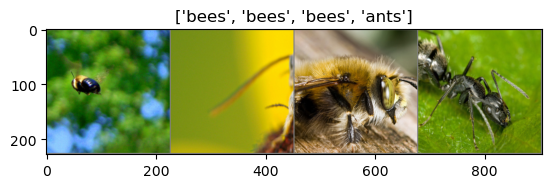

In [42]:
def imshow(inp, title):
    # by default inp = (channels, height, width)
    inp = inp.numpy().transpose((1, 2, 0)) # (height, width, channels)
    inp = std * inp + mean # denormalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [43]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [44]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # fc layer of resnet is replaced by this
model.to(device)

summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# lr updated at each epoch such as: new_lr = lr * gamma^floor(epoch / step_size)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=5)

Epoch 1/5
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 1.0662 Acc: 0.5328


  0%|          | 0/39 [00:00<?, ?it/s]

val Loss: 0.8992 Acc: 0.5556

Epoch 2/5
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.7475 Acc: 0.5492


  0%|          | 0/39 [00:00<?, ?it/s]

val Loss: 0.9294 Acc: 0.5425

Epoch 3/5
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.7373 Acc: 0.5287


  0%|          | 0/39 [00:00<?, ?it/s]

val Loss: 0.7977 Acc: 0.5229

Epoch 4/5
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.7405 Acc: 0.5082


  0%|          | 0/39 [00:00<?, ?it/s]

val Loss: 1.1319 Acc: 0.4967

Epoch 5/5
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.7306 Acc: 0.5123


  0%|          | 0/39 [00:00<?, ?it/s]

val Loss: 0.7939 Acc: 0.5556

Training complete in 0m 18s
Best val Acc: 0.555556


#### ConvNet as feature extractor

In [46]:
model_conv = torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in model_conv.parameters():
    param.requires_grad = False

num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv.to(device)
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)

Epoch 1/5
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.5438 Acc: 0.6967


  0%|          | 0/39 [00:00<?, ?it/s]

val Loss: 0.2391 Acc: 0.9150

Epoch 2/5
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.4233 Acc: 0.8074


  0%|          | 0/39 [00:00<?, ?it/s]

val Loss: 0.2182 Acc: 0.9412

Epoch 3/5
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.7415 Acc: 0.6967


  0%|          | 0/39 [00:00<?, ?it/s]

val Loss: 0.4153 Acc: 0.8366

Epoch 4/5
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.5106 Acc: 0.7746


  0%|          | 0/39 [00:00<?, ?it/s]

val Loss: 0.2706 Acc: 0.8954

Epoch 5/5
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.4966 Acc: 0.7705


  0%|          | 0/39 [00:00<?, ?it/s]

val Loss: 0.2340 Acc: 0.9216

Training complete in 0m 14s
Best val Acc: 0.941176
